In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import random
import pandas as pd
import numpy as np
import graphviz as gr
import data_generate as dgp
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import style
from matplotlib import pyplot as plt
style.use("fivethirtyeight")
os.environ["PATH"] += os.pathsep + 'D:/AppInstall/Graphviz/bin'
random.seed(10)

1.1Simulate Data Generating Process

$y_i = \tau*T_i+a*X_1+b*X_2+e_i$

In [2]:
tau = 2
corr = 0.5
N = 100
Yexp,T,X = dgp.fn_generate_data(tau,100,10,2,0.5, conf = False, flagX=True, select_bias=False) # with two convariates

1.2 DAG

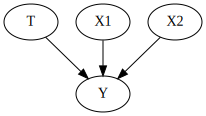

In [3]:
g1 = gr.Digraph("./img")
g1.edge("T", "Y")
g1.edge("X1", "Y")
g1.edge("X2", "Y")
g1

1.3 Monte Carlo

a: Not control corvirate


In [4]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = dgp.fn_generate_data(tau,N,10,2,0.5, conf = False, flagX=False)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = dgp.fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = dgp.fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 275.64it/s]

N=100: bias=-0.0065487532698089695, RMSE=2.4398126888538743, size=0.0595
N=1000: bias=0.005558471436934394, RMSE=0.709126791700558, size=0.051


b: control corvirate

In [5]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = dgp.fn_generate_data(tau,N,10,2,0.5, conf = False, flagX=True)
        Xobs = X[:,:2]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = dgp.fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 252.74it/s]

N=100: bias=-0.0008200084044486264, RMSE=0.1431599825477201, size=0.053
N=1000: bias=0.0004750860996341814, RMSE=0.04540538388001384, size=0.058


From the results, b is much better than the estimated effect of a

1.4 Reality Example

The above DGP method includes determining if a medicine is effective for a patient, whether taking the drug is a treatment variable, and considering the patient's age and metabolic capacity as variables that impact the patient.

2.1 Simulate Data Generating Process

In [6]:
tau = 2
corr = 0.5
N = 100
Yexp,T,X = dgp.fn_generate_data(tau,100,10, 2,0.5, conf = True, flagX=True) # with two convariates and one confounder

2.2 DAG

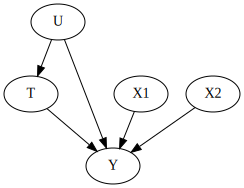

In [7]:
g2 = gr.Digraph("./img")
g2.edge("T", "Y")
g2.edge("U", "Y")
g2.edge("U", "T")
g2.edge("X1", "Y")
g2.edge("X2", "Y")
g2

2.3 Monte Carlo

a: fail control confounder

In [8]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X =dgp.fn_generate_data(tau,100,10, 2,0.5, conf = True, flagX=True)
        Xobs = X[:,1:3]
        covars = np.concatenate([Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = dgp.fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1871.02it/s]

N=100: bias=4.836372492169443, RMSE=7.37159313485678, size=0.8925
N=1000: bias=4.945370661172311, RMSE=7.626722939377765, size=0.8925


b: control confunder 

In [9]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = dgp.fn_generate_data(tau,100,10, 2,0.5, conf = True, flagX=True)
        Xobs = X[:,:3]
        covars = np.concatenate([T, Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = dgp.fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1863.35it/s]

N=100: bias=-0.0016648837532681005, RMSE=0.1613524777753208, size=0.0635
N=1000: bias=0.0035888941923764377, RMSE=0.16187560881874963, size=0.069


From the results, b is much better than the estimated effect of a.

2.4 Reality Example

A treatment variable is determining whether or not a medicine is effective for a particular patient. At the same time, the patient's age and metabolic capacity as factors affecting the patient are consistent with the DGP process described above. If the patient's gender is a confusing factor at this point, it will alter whether the patient is affected at the same time. The aforementioned data generation procedure is used to determine how the drug is taken and how effective it is on the patient.

3.1 Simulate Data Generating Process

In [10]:
tau = 2
corr = 0.5
N = 100
Yexp,T,X = dgp.fn_generate_data(tau,100,10, 2,0.5, conf = True, flagX=True, select_bias=True) 
# with two convariates and one confounder and selection bias

3.2 DAG

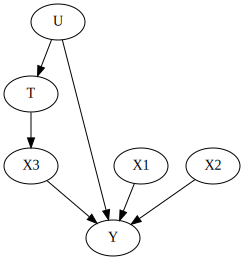

In [11]:
g3 = gr.Digraph("./img")
g3.edge("T", "X3")
g3.edge("X3", "Y")
g3.edge("U", "Y")
g3.edge("U", "T")
g3.edge("X1", "Y")
g3.edge("X2", "Y")
g3

3.3 Monte Carlo

a:control for the variable in between the path from cause to effec

In [12]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T, X = dgp.fn_generate_data(tau,100,10, 2,0.5, conf = True, flagX=True,select_bias=True)
        Xobs = X[:,:3]
        covars = np.concatenate([X[:, -1].reshape(-1,1) * T, Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC0_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = dgp.fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1852.31it/s]

N=100: bias=0.09214867098901726, RMSE=0.22059753676042032, size=0.1075
N=1000: bias=0.08940540382280876, RMSE=0.218634478886415, size=0.1015


b:do not control for the variable in between the path from cause to effect

In [13]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T, X = dgp.fn_generate_data(tau,100,10, 2,0.5, conf = True, flagX=True, select_bias=True)
        Xobs = X[:,:3]
        covars = np.concatenate([T, Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = dgp.fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1825.69it/s]

N=100: bias=-2.0019069457071823, RMSE=2.02401369327879, size=0.9995
N=1000: bias=-2.006279889593926, RMSE=2.028318551344967, size=1.0


From the results, a is much better than the estimated effect of b.

3.4 Reality Example
Testing whether or not a treatment is effective for a patient is a therapeutic variable that influences the drug's efficacy by influencing the patient's antibody concentration. Simultaneously, the patient's age and metabolic capacity as factors impacting the patient are consistent with the DGP procedure described above. If you haven't done so before, now is the moment to do so. The gender of the patient is a confounding factor that influences whether or not the patient takes the treatment, and the drug's effectiveness on the patient is susceptible to the data production procedure described above.
